# Passing run time values to tools

You may need to bind values to a tool that are only known at runtime. For example, the tool logic may require using the ID of the user who made the request.

Most of the time, such values should not be controlled by the LLM. In fact, allowing the LLM to control the user ID may lead to a security risk.

Instead, the LLM should only control the parameters of the tool that are meant to be controlled by the LLM, while other parameters (such as user ID) should be fixed by the application logic.

To pass run time information, we will leverage the [Runnable interface](https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.base.Runnable.html#langchain_core.runnables.base.Runnable).
The standard runnables methods (`invoke`, `batch`, `stream` etc.) accept a 2nd argument which is a [RunnableConfig](https://api.python.langchain.com/en/latest/runnables/langchain_core.runnables.config.RunnableConfig.html). `RunnableConfig` has a few standard fields, but allows users to use other fields for run time information.

Here, we will show how to set up a simple agent that has access to three tools for saving, reading, and deleting a list of the user's favorite pets.

## Setup

First we need to install the packages required

In [41]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_openai

Next, we need to set API keys for OpenAI (the LLM we will use).

In [1]:
import os
import getpass

if 'OPENAI_API_KEY' not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [2]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"

if 'LANGCHAIN_API_KEY' not in os.environ:
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

## Set up the tools

Here, we will make a function that dynamically creates 3 [custom-tools](https://python.langchain.com/docs/modules/agents/tools/custom_tools).

This function will bind to the tools the correct `user_id`, allowing the LLM to only fill in the other relevant values. Importantly,
the LLM will be **unaware** that a user ID even exists!

In [3]:
from typing import List
from langchain_core.tools import tool, BaseTool

# A global dict that the tools will be updating in this example.
user_to_pets = {}

def generate_tools_for_user(user_id: str) -> List[BaseTool]:
    """Generate a set of tools that have a user id associated with them."""
    
    @tool
    def update_favorite_pets(pets: List[str]) -> None:
        """Add the list of favorite pets."""
        user_to_pets[user_id] = pets
    
    @tool
    def delete_favorite_pets() -> None:
        """Delete the list of favorite pets."""
        if user_id in user_to_pets:
            del user_to_pets[user_id]
    
    @tool
    def list_favorite_pets() -> None:
        """List favorite pets if any."""
        return user_to_pets.get(user_id, [])

    return [update_favorite_pets, delete_favorite_pets, list_favorite_pets]

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.


In [4]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

## Define the agent state

The main type of graph in `langgraph` is the `StatefulGraph`.
This graph is parameterized by a state object that it passes around to each node.
Each node then returns operations to update that state.
These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute.
Whether to set or add is denoted by annotating the state object you construct the graph with.

For this example, the state we will track will just be a list of messages.
We want each node to just add messages to that list.
Therefore, we will use a `TypedDict` with one key (`messages`) and annotate it so that the `messages` attribute is always added to.


In [5]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [6]:
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import ToolMessage
from langgraph.prebuilt import ToolExecutor


# Define the function that determines whether to continue or not
def should_continue(state, config):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state, config):
    messages = state["messages"]
    tools = generate_tools_for_user(config['user_id'])
    model_with_tools = model.bind_tools(tools)
    response = model_with_tools.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def call_tool(state, config):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation for each tool call
    tool_invocations = []
    for tool_call in last_message.tool_calls:
        action = ToolInvocation(
            tool=tool_call["name"],
            tool_input=tool_call["args"],
        )
        tool_invocations.append(action)

    # We call the tool_executor and get back a response
    # We can now wrap these tools in a simple ToolExecutor.
    # This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
    # A ToolInvocation is any class with `tool` and `tool_input` attribute.
    tools = generate_tools_for_user(config['user_id'])
    tool_executor = ToolExecutor(tools)
    responses = tool_executor.batch(tool_invocations, return_exceptions=True)
    # We use the response to create tool messages
    tool_messages = [
        ToolMessage(
            content=str(response),
            name=tc["name"],
            tool_call_id=tc["id"],
        )
        for tc, response in zip(last_message.tool_calls, responses)
    ]

    # We return a list, because this will get added to the existing list
    return {"messages": tool_messages}

## Define the graph

We can now put it all together and define the graph!

In [7]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

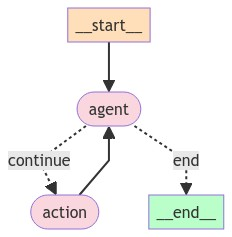

In [8]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

## Use it!

We can now use it!
This now exposes the [same interface](https://python.langchain.com/docs/expression_language/) as all other LangChain runnables.

In [9]:
from langchain_core.messages import HumanMessage

user_to_pets.clear() # Clear the state

print(f'User information prior to run: {user_to_pets}')

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for output in app.stream(inputs, {'user_id': 'eugene'}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

print(f'User information prior to run: {user_to_pets}')

User information prior to run: {}
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_uasiYgme2ptUYOBX0DtsYkuI', 'function': {'arguments': '{"pets":["cats","dogs"]}', 'name': 'update_favorite_pets'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-9f2c8a6c-6427-4c08-865c-aa2750f88808-0', tool_calls=[{'name': 'update_favorite_pets', 'args': {'pets': ['cats', 'dogs']}, 'id': 'call_uasiYgme2ptUYOBX0DtsYkuI'}])]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='None', name='update_favorite_pets', tool_call_id='call_uasiYgme2ptUYOBX0DtsYkuI')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='I have updated your favorite pets to be cats and dogs.', response_metadata={'finish_reason': 'stop'}, id='run-448aa9a6-3fc2-4760-88d7-54d666cce827-0')]}

---

User information prior to run: {'eugene': ['cats', 'dogs']}


In [10]:
print(f'User information prior to run: {user_to_pets}')


inputs = {"messages": [HumanMessage(content="what are my favorite pets?")]}
for output in app.stream(inputs, {'user_id': 'eugene'}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


print(f'User information prior to run: {user_to_pets}')

User information prior to run: {'eugene': ['cats', 'dogs']}
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_YVdogjeOnneDW64pShGbRhCC', 'function': {'arguments': '{}', 'name': 'list_favorite_pets'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-a3c17451-d5ae-43d4-a9cf-ac468ccbd8da-0', tool_calls=[{'name': 'list_favorite_pets', 'args': {}, 'id': 'call_YVdogjeOnneDW64pShGbRhCC'}])]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content="['cats', 'dogs']", name='list_favorite_pets', tool_call_id='call_YVdogjeOnneDW64pShGbRhCC')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='Your favorite pets are cats and dogs.', response_metadata={'finish_reason': 'stop'}, id='run-eef9456f-18b6-4361-8a5d-3924f6febd3c-0')]}

---

User information prior to run: {'eugene': ['cats', 'dogs']}


In [11]:
print(f'User information prior to run: {user_to_pets}')


inputs = {"messages": [HumanMessage(content="please forget what i told you about my favorite animals")]}
for output in app.stream(inputs, {'user_id': 'eugene'}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


print(f'User information prior to run: {user_to_pets}')

User information prior to run: {'eugene': ['cats', 'dogs']}
Output from node 'agent':
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_tQxCShJCYKNzLMxe0Y2vPcI1', 'function': {'arguments': '{}', 'name': 'delete_favorite_pets'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls'}, id='run-183c9064-bf67-4bca-9967-4ae44b75ecb1-0', tool_calls=[{'name': 'delete_favorite_pets', 'args': {}, 'id': 'call_tQxCShJCYKNzLMxe0Y2vPcI1'}])]}

---

Output from node 'action':
---
{'messages': [ToolMessage(content='None', name='delete_favorite_pets', tool_call_id='call_tQxCShJCYKNzLMxe0Y2vPcI1')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content="I have forgotten the information about your favorite animals. If you have any new favorites you'd like to share, feel free to let me know!", response_metadata={'finish_reason': 'stop'}, id='run-259ff9fb-165f-466b-ac6b-4f06cbcf09de-0')]}

---

User information prior to run: {